# 02 · Fine-tuning Eficiente con QLoRA

**Objetivo:** entrenar con QLoRA sobre un dataset pequeño (ej. Alpaca subset) y evaluar pérdidas.

Este notebook muestra, de forma práctica, **cómo reducir memoria y coste de inferencia** en LLMs con cuantización, y cómo hacer **fine-tuning eficiente** con **QLoRA**.

- **Parte A — Cuantización con bitsandbytes (8-bit / 4-bit)**  
Cargamos el mismo modelo en **8-bit (LLM.int8)** y **4-bit (NF4)** usando la API moderna de Transformers (pasando un `BitsAndBytesConfig` en `quantization_config`). Medimos **pico de VRAM**, **tiempo por generación** y **tokens/seg** para comparar. (Transformers documenta que 8-bit suele **reducir la memoria a la mitad**; 4-bit ahorra aún más).

- **Parte B — Fine-tuning con QLoRA (4-bit + LoRA)**  
Entrenamos **solo adapters** (LoRA) encima de un **modelo base cuantizado a 4-bit (NF4)**. QLoRA añade **double quantization** y **paged optimizers** para que el entrenamiento **quepa en una sola GPU** manteniendo calidad cercana a 16-bit en benchmarks (llegando hasta 65B en 48GB en el paper). Implementamos el flujo con **Transformers + PEFT + TRL (SFTTrainer)**.


## 1. Setup

In [1]:
!pip -q install -U transformers datasets peft bitsandbytes accelerate trl



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [15]:
def gpu_peak_gb():
    if not torch.cuda.is_available(): return 0.0
    torch.cuda.synchronize()
    return torch.cuda.max_memory_allocated() / (1024**3)

def gen_and_bench(model, tok, prompt, max_new=64, runs=3):
    device = next(model.parameters()).device
    inputs = tok(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        _ = model.generate(**inputs, max_new_tokens=8)  # warmup
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    total_gen_tokens = 0
    t0 = time.perf_counter()
    with torch.inference_mode():
        for _ in range(runs):
            out = model.generate(**inputs, max_new_tokens=max_new)
            total_gen_tokens += out.shape[-1] - inputs["input_ids"].shape[-1]
    t1 = time.perf_counter()
    sec = (t1 - t0) / runs
    tps = (total_gen_tokens / runs) / sec if sec > 0 else float("nan")
    return sec, tps, gpu_peak_gb()


## 2. Importes y configuraciones


In [1]:
import torch, os
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig

# Modelo pequeño y abierto para demo (cámbialo por tu preferido si quieres)
MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DATASET = "yahma/alpaca-cleaned"   # o cualquier dataset instruct público
OUTPUT_DIR = "/content/qlora-demo"

# Parámetros QLoRA (ajustables)
bnb_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else torch.float16
)

peft_cfg = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj"]  # buen inicio; puedes empezar con ["q_proj","v_proj"]
)



## 3. Cargar modelo 4-bit y tokenizer

In [2]:
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    quantization_config=bnb_4bit,
    device_map="auto"
)

# Alinear PAD para evitar avisos y batching raro
tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

# Preparar k-bit + inyectar LoRA
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

# (Opcional) Gradient checkpointing moderno (evita warning PyTorch 2.4+)
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})

peft_cfg = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj"]  # o ["q_proj","v_proj"]
)

model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()  # aquí ya NO debe salir 0



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


## 4. Dataset y formateo

In [3]:
# Carga dataset y toma un subset pequeño para la demo
raw = load_dataset(DATASET)
train = raw["train"].shuffle(seed=42).select(range(2000))  # ~2k ejemplos para demo
#train = raw["train"].shuffle(seed=42) # Intenta con todo el dataset

# Plantilla simple estilo Alpaca para construir el prompt
def format_sample(example):
    instruction = example.get("instruction","")
    input_ = example.get("input","")
    output = example.get("output","")
    if input_:
        prompt = f"### Instrucción:\n{instruction}\n\n### Entrada:\n{input_}\n\n### Respuesta:\n{output}"
    else:
        prompt = f"### Instrucción:\n{instruction}\n\n### Respuesta:\n{output}"
    return {"text": prompt}

train = train.map(format_sample, remove_columns=train.column_names)



## 5. Config de entrenamiento (TRL SFTTrainer)

In [5]:
# === después de cargar el modelo 4-bit y crear peft_cfg ===
from trl import SFTTrainer, SFTConfig

sft_cfg = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    logging_steps=20,
    save_steps=200,
    report_to="none",
    bf16=(torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8),
    fp16=not (torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8),
    dataloader_pin_memory=torch.cuda.is_available(),
    packing=False,
    dataset_text_field="text",
    max_length=512
)

trainer = SFTTrainer(
    model=model,              # <- base 4-bit, SIN get_peft_model
    peft_config=peft_cfg,     # <- que el trainer inyecte LoRA
    args=sft_cfg,
    train_dataset=train,
    # processing_class=tok,   # opcional si quieres forzar tokenizer
)

# Sanity checks
dl = trainer.get_train_dataloader()
print("Batches:", len(dl))
trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
total = sum(p.numel() for p in trainer.model.parameters())
print(f"Entrenables tras inyección por SFTTrainer: {trainables:,} / {total:,}")

trainer.train()



/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Batches: 1000
Entrenables tras inyección por SFTTrainer: 4,505,600 / 620,111,872


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,1.366300
40,1.216200
60,1.179200
80,1.202700
100,1.151000
120,1.167600
140,1.184900
160,1.239600
180,1.096400
200,1.183500


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=250, training_loss=1.1884027099609376, metrics={'train_runtime': 539.8697, 'train_samples_per_second': 3.705, 'train_steps_per_second': 0.463, 'total_flos': 3492796103589888.0, 'train_loss': 1.1884027099609376, 'entropy': 1.2054669618606568, 'num_tokens': 399581.0, 'mean_token_accuracy': 0.6894352555274963, 'epoch': 1.0})

## 6. Inferencia con adapters (carga y genera)

In [12]:
from peft import PeftModel
from transformers import AutoModelForCausalLM

#ADAPTER_DIR = OUTPUT_DIR  # o el checkpoint exacto, p.ej. "/content/qlora-demo/checkpoint-250"

ADAPTER_DIR = "/content/qlora-demo/checkpoint-250"
# 1) Carga la base 4-bit
base_4bit = AutoModelForCausalLM.from_pretrained(
    MODEL, quantization_config=bnb_4bit, device_map="auto"
)

# 2) Aplica el adapter (¡aquí debe existir adapter_config.json!)
ft_model = PeftModel.from_pretrained(base_4bit, ADAPTER_DIR, is_trainable=False)

prompt = "Explica brevemente por qué la cuantización 4-bit (NF4) funciona bien para afinar LLMs."
inputs = tok(prompt, return_tensors="pt").to(ft_model.device)
with torch.inference_mode():
    out = ft_model.generate(**inputs, max_new_tokens=128)
print(tok.decode(out[0], skip_special_tokens=True))




Explica brevemente por qué la cuantización 4-bit (NF4) funciona bien para afinar LLMs.
Explain briefly why the 4-bit NF4 encoding scheme works well for fine-tuning LLMs.


,config,sec/gen,tok/s,tok/s_std,peak_VRAM_GB
0,FP16 (baseline),1.971630,32.641050,2.379983,7.649432
1,bnb 8-bit (LLM.int8),6.627692,9.671119,0.376939,6.275438
2,bnb 4-bit (NF4),1.796341,17.374556,1.399226,5.862898


CSV guardado en: /content/quantization_benchmark.csv


<Figure size 800x450 with 0 Axes>

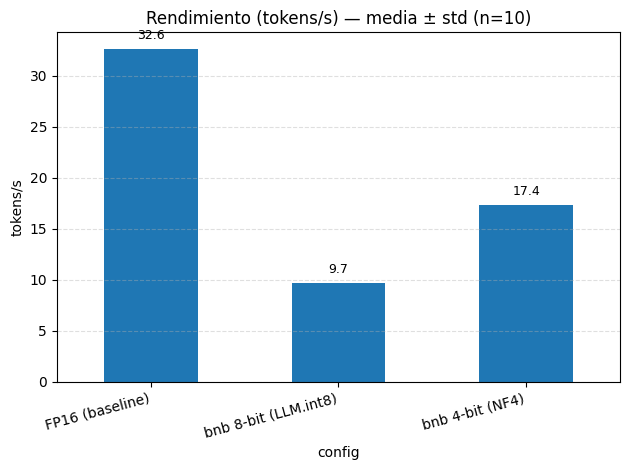

/tmp/ipython-input-3216172615.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


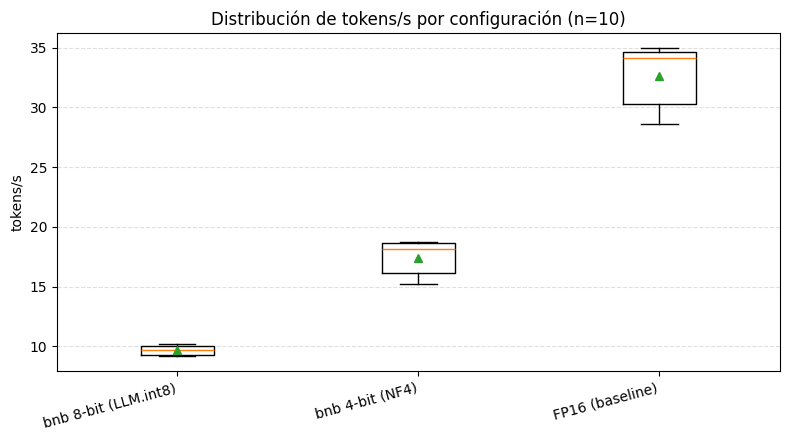

Resumen vs FP16:
- bnb 8-bit (LLM.int8): ahorro VRAM ≈ 18.0% | Δ tokens/s ≈ -70.4% (media n=10)
- bnb 4-bit (NF4): ahorro VRAM ≈ 23.4% | Δ tokens/s ≈ -46.8% (media n=10)


In [19]:
# =========================
#  Comparativa bonita (10 repeticiones + error bars + boxplot)
# =========================
import time, math, statistics as stats
import torch, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from IPython.display import display

# ---------- Parámetros del benchmark ----------
PROMPT = "Explica en 2 frases qué es la cuantización affine."
MAX_NEW_TOKENS = 64
RUNS = 10            # ← más fiable (múltiples muestras)
DO_FP16 = True       # pon False si tu GPU no soporta el baseline FP16

# ---------- Tokenizer (si no existe, lo cargamos) ----------
if 'tok' not in globals():
    tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

# ---------- Helpers (fallbacks si no tienes la Celda 1) ----------
def _gpu_peak_gb_fallback():
    if not torch.cuda.is_available(): return 0.0
    torch.cuda.synchronize()
    return torch.cuda.max_memory_allocated() / (1024**3)

if 'gpu_peak_gb' not in globals():
    gpu_peak_gb = _gpu_peak_gb_fallback

def gen_and_bench_multi(model, tok, prompt, max_new=64, runs=10):
    """Devuelve: dict con 'sec_list', 'tps_list', 'sec_mean', 'tps_mean', 'tps_std', 'peak_gb'."""
    device = next(model.parameters()).device
    inputs = tok(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        _ = model.generate(**inputs, max_new_tokens=8)  # warmup
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    sec_list, tps_list = [], []
    with torch.inference_mode():
        for _ in range(runs):
            t0 = time.perf_counter()
            out = model.generate(**inputs, max_new_tokens=max_new)
            t1 = time.perf_counter()
            gen_tokens = (out.shape[-1] - inputs["input_ids"].shape[-1])
            sec = (t1 - t0)
            tps = (gen_tokens / sec) if sec > 0 else float("nan")
            sec_list.append(sec)
            tps_list.append(tps)

    peak = gpu_peak_gb()
    return {
        "sec_list": sec_list,
        "tps_list": tps_list,
        "sec_mean": sum(sec_list)/len(sec_list),
        "tps_mean": sum(tps_list)/len(tps_list),
        "tps_std":  stats.pstdev(tps_list) if len(tps_list) > 1 else 0.0,
        "peak_gb":  peak
    }

# ---------- Ejecutar comparativa ----------
rows = []
per_run = {}  # guardará las listas por config para boxplot

# 8-bit (LLM.int8)
bnb_8 = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0, llm_int8_has_fp16_weight=False)
m8 = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_8, device_map="auto")
res8 = gen_and_bench_multi(m8, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
rows.append({"config":"bnb 8-bit (LLM.int8)", "sec/gen": res8["sec_mean"], "tok/s": res8["tps_mean"], "tok/s_std": res8["tps_std"], "peak_VRAM_GB": res8["peak_gb"]})
per_run["bnb 8-bit (LLM.int8)"] = res8["tps_list"]
del m8;
if torch.cuda.is_available(): torch.cuda.empty_cache()

# 4-bit (NF4 + double-quant)
bnb_4 = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=(torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else torch.float16)
)
m4 = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_4, device_map="auto")
res4 = gen_and_bench_multi(m4, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
rows.append({"config":"bnb 4-bit (NF4)", "sec/gen": res4["sec_mean"], "tok/s": res4["tps_mean"], "tok/s_std": res4["tps_std"], "peak_VRAM_GB": res4["peak_gb"]})
per_run["bnb 4-bit (NF4)"] = res4["tps_list"]
del m4;
if torch.cuda.is_available(): torch.cuda.empty_cache()

# (Opcional) FP16 baseline
HAVE_FP16 = False
if DO_FP16:
    try:
        m0 = AutoModelForCausalLM.from_pretrained(MODEL, torch_dtype="auto", device_map="auto")
        res0 = gen_and_bench_multi(m0, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
        rows.insert(0, {"config":"FP16 (baseline)", "sec/gen": res0["sec_mean"], "tok/s": res0["tps_mean"], "tok/s_std": res0["tps_std"], "peak_VRAM_GB": res0["peak_gb"]})
        per_run["FP16 (baseline)"] = res0["tps_list"]
        HAVE_FP16 = True
        del m0
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    except Exception as e:
        print("⚠️ FP16 no se cargó (VRAM insuficiente). Continuamos sin baseline.")

# ---------- Tabla + CSV con media y std ----------
df = pd.DataFrame(rows)
display(df)

CSV_PATH = "/content/quantization_benchmark.csv"
df.to_csv(CSV_PATH, index=False)
print(f"CSV guardado en: {CSV_PATH}")

# ---------- Gráfico 1: Barras con barras de error (tok/s) ----------
plt.figure(figsize=(8,4.5))
ax = df.plot(kind="bar", x="config", y="tok/s", yerr=df["tok/s_std"], capsize=4, legend=False)
plt.title("Rendimiento (tokens/s) — media ± std (n=10)")
plt.ylabel("tokens/s")
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
# Anotar valores encima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}", (p.get_x() + p.get_width()/2, height),
                xytext=(0, 5), textcoords="offset points", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# ---------- Gráfico 2: Boxplot de tok/s por configuración ----------
plt.figure(figsize=(8,4.5))
labels = list(per_run.keys())
data   = [per_run[k] for k in labels]
plt.boxplot(data, labels=labels, showmeans=True)
plt.title("Distribución de tokens/s por configuración (n=10)")
plt.ylabel("tokens/s")
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- Resumen vs FP16 (si existe) ----------
def summary_vs_fp16(df, baseline="FP16 (baseline)"):
    if baseline not in df["config"].values:
        return "No hay baseline FP16; compara 8-bit vs 4-bit directamente."
    base = df.set_index("config").loc[baseline]
    lines = []
    for _, row in df.iterrows():
        if row["config"] == baseline: continue
        vram_saving = (base["peak_VRAM_GB"] - row["peak_VRAM_GB"]) / base["peak_VRAM_GB"] * 100.0
        tps_gain    = (row["tok/s"]      - base["tok/s"])       / base["tok/s"]       * 100.0
        lines.append(f"- {row['config']}: ahorro VRAM ≈ {vram_saving:.1f}% | Δ tokens/s ≈ {tps_gain:.1f}% (media n=10)")
    return "Resumen vs FP16:\n" + "\n".join(lines)

print(summary_vs_fp16(df))




In [20]:
import pandas as pd


df = pd.read_csv(CSV_PATH)

CSV_PATH = "/content/quantization_benchmark.csv"

try:
    df.to_csv(CSV_PATH, index=False)
    print(f"CSV guardado en: {CSV_PATH}")
except NameError:
    print("⚠️ 'df' no existe en este notebook. Ejecuta primero la comparativa 8-bit/4-bit para generarlo.")

def summary_vs_fp16(df, baseline="FP16 (baseline)"):
    if baseline not in df["config"].values:
        return "No se encontró baseline FP16; no se puede calcular resumen relativo."
    base = df.set_index("config").loc[baseline]
    lines = []
    for _, row in df.iterrows():
        if row["config"] == baseline:
            continue
        vram_saving = (base["peak_VRAM_GB"] - row["peak_VRAM_GB"]) / base["peak_VRAM_GB"] * 100.0
        tps_gain = (row["tok/s"] - base["tok/s"]) / base["tok/s"] * 100.0
        lines.append(f"- {row['config']}: ahorro VRAM ≈ {vram_saving:.1f}% | mejora tokens/s ≈ {tps_gain:.1f}%")
    return "Resumen vs FP16:\n" + "\n".join(lines)

# Solo imprime si df existe
try:
    print(summary_vs_fp16(df))
except NameError:
    pass


CSV guardado en: /content/quantization_benchmark.csv
Resumen vs FP16:
- bnb 8-bit (LLM.int8): ahorro VRAM ≈ 18.0% | mejora tokens/s ≈ -70.4%
- bnb 4-bit (NF4): ahorro VRAM ≈ 23.4% | mejora tokens/s ≈ -46.8%


# ✅ Conclusiones

- **Cuantizar funciona ya**: con **8-bit (LLM.int8)** se suele lograr ~**50% menos VRAM** con mínima pérdida de calidad; **4-bit (NF4)** reduce aún más la memoria con algo más de riesgo (según tarea/modelo). La forma recomendada hoy en Transformers es pasar `BitsAndBytesConfig` en `quantization_config`.


- **QLoRA = LoRA + base 4-bit**: permite **afinar modelos grandes en una sola GPU** gracias a **NF4**, **double quantization** y **paged optimizers**, manteniendo resultados cercanos a 16-bit. :contentReference[oaicite:6]{index=6}
- **Receta portable**: el stack **Transformers + PEFT + TRL (SFTTrainer)** simplifica el SFT con adapters y es fácil de trasladar a otros modelos y datasets.


## 🧪 ¿Qué pueden experimentar?

- **Conmutar 8-bit ↔ 4-bit**: cambiar `BitsAndBytesConfig` (p.ej., `bnb_4bit_quant_type = "nf4"` vs `"fp4"`) y observar **VRAM / tokens-s**.

- **Ajustar LLM.int8**: probar distintos valores de `llm_int8_threshold` y ver el efecto en rendimiento/estabilidad.

- **Longitud del prompt**: medir latencia con prompts cortos vs largos (la **KV-cache** domina en secuencias largas).  
- **LoRA/QLoRA**: variar **r** y **lora_alpha**, y el conjunto de `target_modules` (p.ej., `["q_proj","v_proj"]` vs añadir `k_proj/o_proj`) para ver impacto en calidad y estabilidad.

- **SFT con TRL**: cambiar el tamaño del dataset y el `max_seq_length`; observar si mejora la salida en tu tarea.

> **Próximos pasos**: evaluar **AWQ/GPTQ** (weight-only) soportados por Transformers para servir checkpoints 4-bit listos, y añadir métricas de **tarea** (perplexity, EM, preferencia humana) además de la velocidad.